 # 第 4 章 广义线性回归模型

<style>p{text-indent:2em;2}</style>

在上一章中，使用自变量的线性组合来预测因变量的平均值，其中假设因变量为高斯分布。在许多情况下都可以使用高斯分布，但对于其他许多情况，选择其他分布可能更明智。例如：使用学生 $t$ 分布替换高斯分布时，可有效解决异常值问题，使推断更为稳健。本章将介绍更多使其他分布的例子。此外，正如即将介绍的，存在一个通用的模式，可将线性模型推广到许多问题中。

本章将会讨论以下内容：

- `广义线性模型`
- Logistic 回归和`逆连接函数`
- `简单 Logistic 回归` 
- `多元 Logistic 回归` 
- `Softmax 函数`和 `多分类 Logistic 回归` 
- `泊松回归`
- `零膨胀泊松回归`

---

## 4.1 广义线性回归

本章的核心思想相当简单：`为预测因变量的平均值，可以对自变量的线性组合应用任意函数`。

```{math}
\mu = f ( \alpha + X \beta ) \tag{式4.1} \label{式4.1}
```

其中， $f$ 称作`逆连接函数`。为什么这里把 $f$ 称作 『逆连接函数』 而不是 『连接函数』 ？ 原因是传统上人们认为 『连接函数』 是用来连结因变量和线性模型的。而在构建贝叶斯模型时，反过来思考（即连接线性模型和因变量）可能更容易理解一些。因此，为避免疑惑本文统称 『逆连接函数』。前一章中所有线性模型其实都包含一个逆连接函数，不过书写时省略了，因为它其实是一个恒等函数（函数的返回值和输入值相同）。恒等函数在此没什么用，但有助于让我们用更一般的形式思考模型。

希望使用逆连接函数的一种情况是处理离散型的定类变量，例如：颜色名称、性别、生物物种、政党/从属关系等。它们都无法用高斯分布建模，因为高斯函数仅适用于实数集上的连续变量。可以考虑调整数据的分布，不过这需要改变建模方法，例如：如果使用二项分布，就需要一个因变量分布的平均值在 $[0, 1]$ 区间内的模型。要实现这种模型，可以保留原先的线性模型，但使用逆连接函数将输出限制在所需区间内。当然，此技巧并不局限于离散变量，例如：实践中可能只对取正值的数据建模，因此希望将线性模型限制为因变量分布的平均值为正值，例如伽马或指数分布。

```{note}
请注意：某些变量可以被编码为定量的，也可以编码成定性的。这需要根据所研究问题的上下文做出决定。例如：在讨论颜色名称时，既可以采用取值为 『红色』 或 『绿色』 的定性变量，也可以使用取值为 『650』 nm 和 『510』 nm 的定量变量。
```

## 4.2 面向二分类的一元 Logistic 回归

回归任务在给定一个或多个自变量的值的情况下，预测因变量的连续值。与此不同，分类任务在给定一些自变量的值时，将某些离散值赋给因变量。两种情况的核心任务都是`获得一个能够正确模拟因变量与自变量间映射的模型`。为此需要具有正确的 『因变量--自变量』 样本集。从机器学习视角看，回归任务和分类任务都属于监督学习。

Logistic 回归虽然名字中带有 『回归』 字眼，但其实际解决的是分类问题。 Logistic 回归模型是线性回归模型的扩展。其模型是将 `式 4.1` 中的逆连接函数设定为 Logistic 函数而形成， Logistic 函数形式以下：

```{math}
\operatorname{logistic}(z)=\frac{1} { 1 + e ^ { - z } } \tag{式4.2} \label{式4.2}
```

从分类角度看， Logistic 函数最重要的特点是不论输入参数 $z$ 值为多少，其输出总是介于 0 到 1 之间。因此，该函数可以将整个实轴压缩到了区间 $[ 0,1 ]$ 内。 Logistic 函数也称作 `S 型函数（sigmoid function）`，因为其形状看起来像 S 。

下面代码绘制了 S 型函数的图形：

In [1]:
import matplotlib.pyplot as plt
import scipy.stats as stats
import numpy as np
import pandas as pd
import seaborn as sns
import pymc3 as pm
import arviz as az

az.style.use('arviz-darkgrid')

Text(0, 0.5, 'logistic(z)')

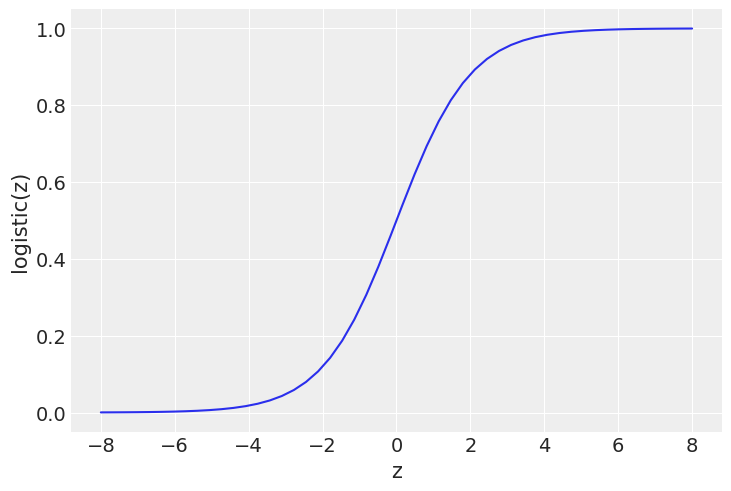

In [2]:
z = np.linspace(-8, 8)
plt.plot(z, 1 / (1 + np.exp(-z)))
plt.xlabel('z')
plt.ylabel('logistic(z)')

<center>

<img src="https://gitee.com/XiShanSnow/imagebed/raw/master/images/articles/spatialPresent_20210505115639_54.webp" style="zoom:67%;" />

图 4.1
</center>

### （1）Logistic 模型

至此我们已经具备了将简单线性回归转化为简单 Logistic 回归的所有要素。

先从简单问题开始，假设因变量取值只有两类，比如正常邮件/垃圾邮件、安全/不安全、阴天/晴天、健康/生病等。首先对类别进行编码，假设变量 $y$ 只能有两个值 0 或 1 。 这样表述就有点类似抛硬币问题了。我们可以使用在`第 2 章`的抛硬币问题中曾采用伯努利分布作为似然，来建模此处的二分类问题。与抛硬币问题不同的是：$\theta$ 来自于一个简单线性模型，而非从贝塔分布中生成。

由于简单线性模型能够返回实轴上任意值，而伯努利分布的输入值限定在 $[ 0,1 ]$ 区间内。因此，可以使用 Logistic 函数作为逆连接函数，将线性模型的返回值映射到适合伯努利分布的区间内，从而将线性回归模型转换成分类模型：

\begin{align*} \tag{式 4.3} \\label{式4.3}
\theta &=\operatorname{logistic}(\alpha+x \beta) \\
 y &= \operatorname{Bern}(\theta) 
\end{align*} 

下面的 Kruschke 图显示了 Logistic 回归模型。注意与简单线性回归模型的区别是：

- 为适合离散型变量建模，因变量采用了伯努利分布，而不是高斯分布（或者学生 $t$ 分布）

- 为适合于使用伯努利分布，逆连接函数使用了 Logistic 函数生成 $[ 0,1 ]$ 区间内的 $θ$ 参数值，而非恒等函数。

<center>

<img src="https://gitee.com/XiShanSnow/imagebed/raw/master/images/articles/spatialPresent_20210429224141_27.webp" style="zoom:50%;" />

</center>

### （2）关于 Iris 数据集

我们将 Logistic 回归应用到 Iris 数据集上。在构建模型之前先了解下该数据集。

Iris 数据集是经典数据集，包含有 `Setosa` 、 `Versicolour` 和 `Virginica` 3 个种类，这 3 个类别标签就是要预测的量，即因变量。其中每个种类包含 50 个数据，每个数据包含 4 种变量（或称为特征），这 4 种变量就是待分析的自变量，分别是：花瓣长度、花瓣宽度、花萼长度和花萼宽度。花萼有点类似小叶，在花还是芽时包围着花，有保护作用。

seaborn 软件包中包含 Iris 数据集，可以用如下代码将其导入成 `Pandas` 的 `DataFrame`：

In [3]:
iris = pd.read_csv('../data/iris.csv')
iris.head()

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


<center>

![](https://gitee.com/XiShanSnow/imagebed/raw/master/images/articles/spatialPresent_20210429224345_c1.webp)

</center>

现在，可以使用 seaborn 软件包中的 `stripplot` 函数绘制这三个物种与 `stepal_length` 的关系图：

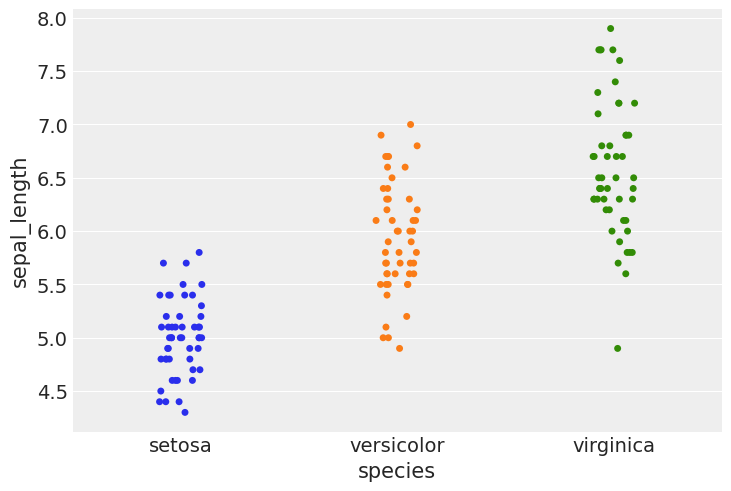

In [4]:
sns.stripplot(x="species", y="sepal_length", data=iris, jitter=True)

<center>

<img src="https://gitee.com/XiShanSnow/imagebed/raw/master/images/articles/spatialPresent_20210429224514_92.webp" style="zoom:67%;" />

图 4.2
</center>

上图中 $y$ 轴是连续的，而 $x$ 轴是离散的；图中在 $x$ 轴上散布的点并没有什么实际意义，只是一个画图技巧而已，通过将 `jitter` 参数设为 `True`，避免所有点都重叠在一条直线上。你可以尝试将 `jitter` 参数设为 `False`。这里唯一重要的是 $x$ 轴的含义，分别代表 `Setosa` 、 `Versicolour` 和 `Virginica` 三个类别。还可以用 seaborn 软件包中其他绘图函数（如 `violinplot` ）来画这些点，只需要一行代码就能完成。

此外可以使用 `pairplot` 函数画出散点图矩阵，用该函数可以得到一个 4×4 网格（因为有 4 种特征）。网格是对称的，上三角和下三角表示同样的信息。由于对角线上的散点图其实是变量本身，因此用一个特征的 KDE 图代替了散点图。可以看到，每个子图中分别用 3 种颜色表示 3 种不同的类别标签，与前面图中的表示方法一致。

/opt/hostedtoolcache/Python/3.8.11/x64/lib/python3.8/site-packages/seaborn/axisgrid.py:88: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  self._figure.tight_layout(*args, **kwargs)


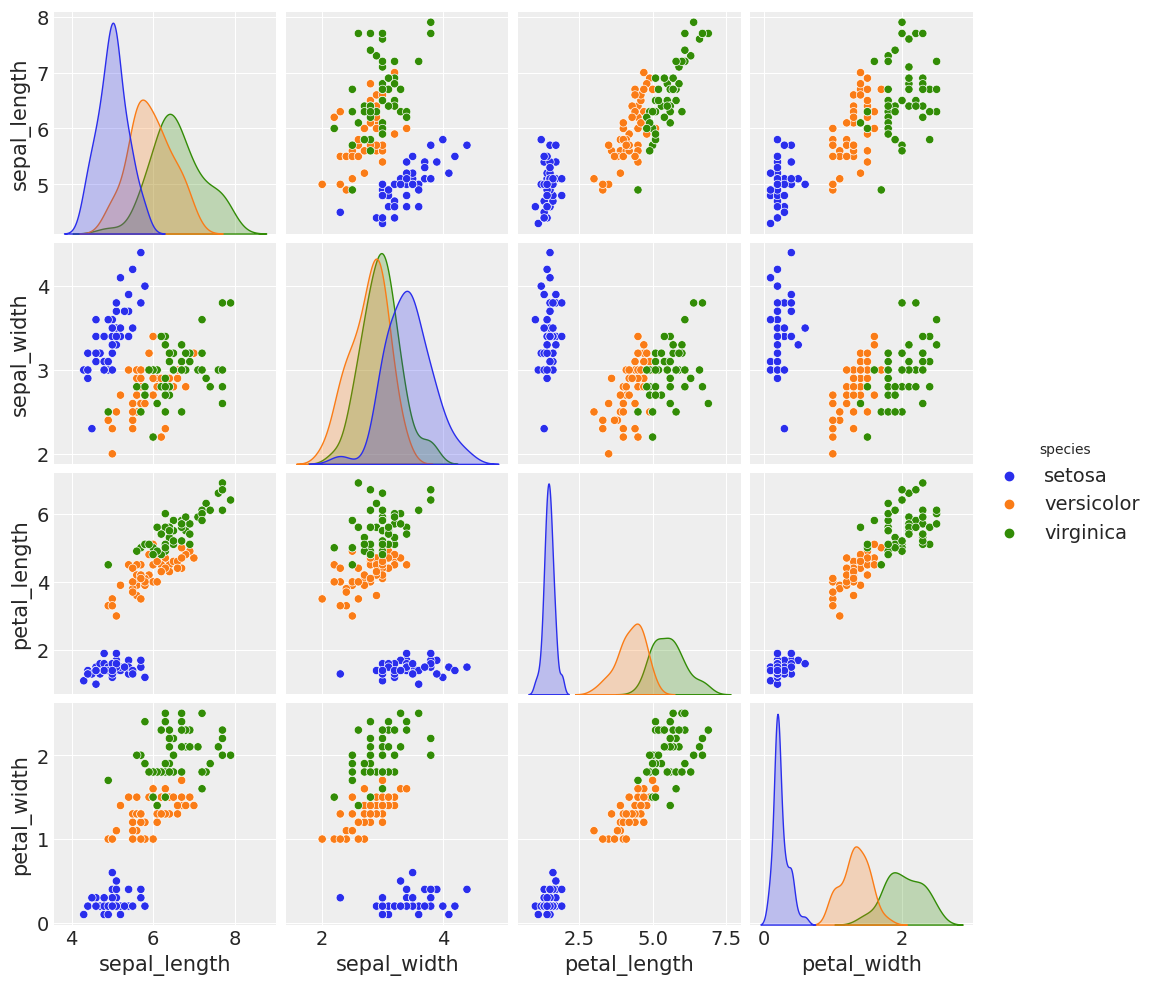

In [5]:
sns.pairplot(iris, hue='species', diag_kind='kde')

<center>

<img src="https://gitee.com/XiShanSnow/imagebed/raw/master/images/articles/spatialPresent_20210429224656_78.webp" style="zoom:67%;" />

图 4.3
</center>

在深入学习之前，花点时间分析下前面这幅图，进一步熟悉该数据集并了解变量与分类标签之间的关系。

### （3）将 Logistic 回归模型应用到 Iris 数据集

先从一个简单的问题开始：用花萼长度这一特征（自变量）来区分 `Setosa` 和 `Versicolour` 两个种类。

和前面一样，这里用 0 和 1 对因变量 $\mathbf{y}$ 进行编码，利用 `Pandas` 可以这么做：

In [6]:
df = iris.query("species == ('Setosa', 'Versicolour')")
y_0 = pd.Categorical(df['species']).codes
x_n = 'sepal_length'
x_0 = df[x_n].values
x_c = x_0 - x_0.mean()

/tmp/ipykernel_2451/2603014128.py:5: RuntimeWarning: Mean of empty slice.
  x_c = x_0 - x_0.mean()
/opt/hostedtoolcache/Python/3.8.11/x64/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


现在数据已经表示成了合适的格式，可以用 `PyMC3` 建模了。留意下面代码中的第一部分与线性回归模型的相似之处。此外留意两个确定变量： $\theta$ 和 `bd` 。 $\theta$ 是对变量 $\mu$ 应用 Logistic 函数之后的值（ 位于 $[ 0,1 ]$ 区间内），`bd` 是决策边界的值，用于确定分类结果，至于为何会选择 $bd = -\alpha / \beta$ 稍后会做详细讨论。

此外，除了像下面写出 Logistic 函数的完整形式外，还可以使用 `PyMC3` 中现成的 `pm.math.sigmoid` 函数，该函数是 `Theano` 中 `sigmoid` 函数的别名。

In [7]:
with pm.Model() as model_0:
   α = pm.Normal('α', mu=0, sd=10)
   β = pm.Normal('β', mu=0, sd=10)
   μ = α + pm.math.dot(x_c, β)
   θ = pm.Deterministic('θ', pm.math.sigmoid(μ)) 
   bd = pm.Deterministic('bd', -α/β)
   yl = pm.Bernoulli('yl', p=θ, observed=y_0)
   
   trace_0 = pm.sample(1000)

WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: TensorConstant{[]}


WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: TensorConstant{[]}


WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{ge,no_inplace}.0


WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{le,no_inplace}.0


WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: θ


WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{add,no_inplace}.0


WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{add,no_inplace}.0


WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: TensorConstant{[]}


WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: TensorConstant{[]}


/tmp/ipykernel_2451/2411449454.py:9: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace_0 = pm.sample(1000)
Auto-assigning NUTS sampler...


Initializing NUTS using jitter+adapt_diag...


WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: TensorConstant{[]}


WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: TensorConstant{[]}


WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{ge,no_inplace}.0


WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{le,no_inplace}.0


WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: θ


WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{add,no_inplace}.0


WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{add,no_inplace}.0


WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: TensorConstant{[]}


WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: TensorConstant{[]}


WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: TensorConstant{[]}


WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: TensorConstant{[]}


WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{ge,no_inplace}.0


WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{le,no_inplace}.0


WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: θ


WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{add,no_inplace}.0


WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{add,no_inplace}.0


WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: TensorConstant{[]}


WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: TensorConstant{[]}


WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: θ


WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: TensorConstant{[]}


WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{add,no_inplace}.0


WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{add,no_inplace}.0


WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: TensorConstant{[]}


WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{ge,no_inplace}.0


WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{le,no_inplace}.0


WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: θ


WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: TensorConstant{[]}


WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: TensorConstant{[]}


WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: TensorConstant{[]}


WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{ge,no_inplace}.0


WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{le,no_inplace}.0


WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: θ


WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{add,no_inplace}.0


WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{add,no_inplace}.0


WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: TensorConstant{[]}


WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: TensorConstant{[]}


WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: TensorConstant{[]}


WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: TensorConstant{[]}


WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{ge,no_inplace}.0


WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{le,no_inplace}.0


WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: θ


WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{add,no_inplace}.0


WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{add,no_inplace}.0


WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: TensorConstant{[]}


WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: TensorConstant{[]}


Sequential sampling (2 chains in 1 job)


NUTS: [β, α]


WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{mul,no_inplace}.0


WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: TensorConstant{[]}


ValueError: Sampling stopped before a sample was created.

为节省页数，同时避免对同一类型图件反复出现感到厌烦，将省略迹图和其他类似的摘要图，但鼓励您制作自己的迹图和摘要，以进一步探索本书中的例子。我们将直接跳到如何生成下图，这是一个数据曲线图，以及拟合的 `sigmoid` 曲线和决策边界：

In [ ]:
theta = trace_0['θ'].mean(axis=0)
idx = np.argsort(x_c)
plt.plot(x_c[idx], theta[idx], color='C2', lw=3)
plt.vlines(trace_0['bd'].mean(), 0, 1, color='k')
bd_hpd = az.hpd(trace_0['bd'])
plt.fill_betweenx([0, 1], bd_hpd[0], bd_hpd[1], color='k', alpha=0.5)
plt.scatter(x_c, np.random.normal(y_0, 0.02),
            marker='.', color=[f'C{x}' for x in y_0])
az.plot_hpd(x_c, trace_0['θ'], color='C2')
plt.xlabel(x_n)
plt.ylabel('θ', rotation=0)
# use original scale for xticks
locs, _ = plt.xticks()
plt.xticks(locs, np.round(locs + x_0.mean(), 1))

<center>

<img src="https://gitee.com/XiShanSnow/imagebed/raw/master/images/articles/spatialPresent_20210429225650_74.webp" style="zoom:67%;" />

图 4.4
</center>

前面这张图表示了花萼长度与花种类（ `Setosa = 0, Versicolour = 1`）之间的关系。绿色的 $S$ 型曲线表示 $\theta$ 的均值，这条线可以解释为：在知道花萼长度的情况下花的种类是 `Versicolour` 的概率，即半透明的绿色区间是 `94% HPD 区间`。边界判定用一条（黑色）垂直线表示，其 94%的 HPD 为半透明带。根据边界判定，左侧的值（在本例中为萼片长度）对应于 类 0 （ `Setosa` ），右侧的值对应于类 1 （ `Versicolour` ）。

决策边界由 $y=0.5$ 时的 $x$ 取值定义，可以证明其结果为 $-\frac{\alpha}{\beta}$ ，推导过程如下：

根据模型的定义，有如下关系：

```{math}
\theta=\operatorname{logistic}(\alpha+x \beta) \tag{式4.4} \label{式4.4}
```

根据 Logistic 函数的定义，当 $\theta=0.5$ 时，对应的输入为 0 点，因此有：

```{math}
0.5=\operatorname{logistic}\left(\alpha+x_{i} \beta\right) \Leftrightarrow 0=\alpha+x_{i} \beta \tag{式4.5} \label{式4.5}
```

移项后可以得出，当 $\theta=0.5$ 时，决策边界对应为：

```{math}
x_{i}=-\frac{\alpha}{\beta} \tag{式4.6} \label{式4.6}
```

值得一提的是：

- 通常 $\theta$ 的值是 $y$ 属于类别 1 的概率 $p(y=1|x)$ 。从这点上来说， Logistic 回归是一种真正的回归；关键细节是，在给定特征的线性组合的情况下，回归的是数据点属于类别 1 的概率。

- 我们拟合的是一个二值变量的平均值，即 $[0,1]$ 区间内的一个数字。然后引入一种规则（此处为伯努利），将该数字转化为二分类赋值。通常，如果 $p(y=1)>=0.5$ ，分配类 1 ，否则分配类 0 。

- 上述选取的 0.5 并不是指定的特殊值，根据问题上下文，你完全可以选择其他 0 到 1 之间的值。本例中，只有当我们认为将标签 0（ `Setosa` ）错误地标为标签 1（ `Versicolour`）时的代价，与反过来将标签 1（ `Versicolour` ）错误地标为标签 0（ `Setosa` ）时的代价相同时，选取 0.5 作为决策边界才是可行的。不过大多数情况下，分类出错的代价并不对称。

## 4.3 面向二分类的多元 Logistic 回归

与多元线性回归类似，`多元 Logistic 回归` 使用多个自变量。这里举例将花萼长度与花萼宽度结合在一起，注意需要对数据做一些预处理。

In [ ]:
df = iris.query("species == ('setosa', 'versicolor')")
y_1 = pd.Categorical(df['species']).codes
x_n = ['sepal_length', 'sepal_width']
x_1 = df[x_n].values

### 4.3.1 高维空间的决策边界

如果你对如何推导决策边界不感兴趣的话，可以略过这个部分直接跳到模型实现部分。 根据模型，我们有：

```{math}
\theta=\operatorname{logistic}\left(\alpha+\beta_{1} x_{1}+\beta_{2} x_{2}\right) \tag{式4.7} \label{式4.7}
```

从 Logistic 函数的定义出发，当 Logistic 回归的自变量为零时，有 $\theta=0.5$ 。对应：

```{math}
0.5=\operatorname{logistic}\left(\alpha+\beta_{1} x_{1}+\beta_{2} x_{2}\right) \Leftrightarrow 0=\alpha+\beta_{1} x_{1}+\beta_{2} x_{2} \tag{式4.8} \label{式4.8}
```

通过移项，我们找到 $\theta=0.5$ 时 $x_2$ 的值：

```{math}
x_{2}=-\frac{\alpha}{\beta_{2}}+\left(-\frac{\beta_{1}}{\beta_{2}} x_{1}\right) \tag{式4.9} \label{式4.9}
```

这个决策边界的表达式与直线的表达式在数学形式上是一样的，其中第 1 项表示截距，第 2 项表示斜率，这里的括号只是为了表达上更清晰，如果你愿意的话完全可以去掉。

为什么决策边界是直线呢？

想想看，如果我们只有一个特征，也就是在一维数据空间，可以用一个点将数据分成两组；如果有两个特征，也就是在二维数据空间，可以用一条直线将数据分为两组；对于三维的情况，边界应当是一个平面；而对于更高维度，边界应当是一个超平面。实际上超平面是一个通用概念，可以大致定义为 $n$ 维空间中的 $n-1$ 维子空间，因此在涉及高维问题时，一般将决策边界统一称为超平面。

### 4.3.2 模型实现

如果要用 `PyMC3` 写出多元 Logistic 回归模型，可以借助其向量化表示的优势，只需对单参数 Logistic 回归模型做一些简单修改即可。

In [ ]:
with pm.Model() as model_1:
    α = pm.Normal('α', mu=0, sd=10)
    β = pm.Normal('β', mu=0, sd=2, shape=len(x_n))
    μ = α + pm.math.dot(x_1, β)
    θ = pm.Deterministic('θ', 1 / (1 + pm.math.exp(-μ)))
    bd = pm.Deterministic('bd', -α/β[1] - β[0]/β[1] * x_1[:,0])
    yl = pm.Bernoulli('yl', p=θ, observed=y_1)

    trace_1 = pm.sample(2000)

绘制数据和决策边界：

In [ ]:
idx = np.argsort(x_1[:,0])
bd = trace_1['bd'].mean(0)[idx]
plt.scatter(x_1[:,0], x_1[:,1], c=[f'C{x}' for x in y_0])
plt.plot(x_1[:,0][idx], bd, color='k');

az.plot_hpd(x_1[:,0], trace_1['bd'], color='k')

plt.xlabel(x_n[0])
plt.ylabel(x_n[1]

决策边界现在是一条直线，不要被 `95% HPD 区间`的曲线给误导了。图中半透明的曲线是由于在中间部分多条直线绕中心区域旋转的结果（大致围绕 $x$ 的平均值 和 $y$ 的平均值）。

<center>

<img src="https://gitee.com/XiShanSnow/imagebed/raw/master/images/articles/spatialPresent_20210505135608_4a.webp" alt="image-20210429232402489" />

图 4.5
</center>

### 4.3.3 关于 Logistic 回归系数的解释

在解释 Logistic 回归的 $\beta$ 系数时，必须非常小心。因为解释并不像`第 3 章『线性回归模型』`中讨论线性模型时那样简单。此处使用 Logistic 逆连接函数引入了非线性。如果 $\beta$ 为正，则增加 $x$ 会增加一些 $p(y=1)$ 的量，但该量值不是 $x$ 的线性函数，而是非线性地依赖于 $x$ 值。可以在上面一系列图中直观地看到这一事实；我们看到的不是具有恒定斜率的直线，而是随 $x$ 值变化而不断调整斜率的 $S$ 形曲线。代数知识可以让我们更深入地了解 $p(y=1)$ 如何随 $\beta$ 变化。基础模型是：

```{math}
\theta=\operatorname{logistic}(\alpha+X \beta) \tag{式4.10} \label{式4.10}
```

Logistic 函数的逆函数是 `logit 函数`，它是：

```{math}
\operatorname{logit}(z)=\log \left(\frac{z}{1-z}\right) \tag{式4.11} \label{式4.11}
```

因此，如果在`式 4.11 `两边同时取`logit 函数` ，会得到：

```{math}
\operatorname{logit}(\theta)=\alpha+X \beta \tag{式4.12} \label{式4.12}
```

或等价的：

```{math}
\log \left(\frac{\theta}{1-\theta}\right)=\alpha+X \beta \tag{式4.13}  \label{式4.13}
```

记住模型中的 $\theta$ 定义为 $y=1$ 的概率 $p(y=1)$ ：

```{math}
\log \left(\frac{p(y=1)}{1-p(y=1)}\right)=\alpha+X \beta \tag{式4.14} \label{式4.14}
```

 $\frac{p(y=1)}{1-p(y=1)}$ 的量值被称为赔率。

成功的赔率被定义为成功概率与不成功概率之比。虽然掷一个公平骰子得到 2 的概率是 1/6 ，但同一事件的赔率是 $\frac{1/6}{5/6}=0.2$ 或 1 个有利事件对 5 个不利事件。赌徒经常使用赔率，因为在考虑下注方式时，赔率作为相对值，提供了一种比原始概率更直观的工具。

在 Logistic 回归模型中，系数 $\beta$ 编码了赔率对数随变量 $x$ 单位变化而变化的情况。

概率到赔率的转换具有单调性，意味着赔率随概率的增加而增加，随概率的减少而减少。概率被限制在 $[0, 1]$ 区间，而赔率则在 $[0，∞)$ 区间内。对数运算也是单调变换，赔率对数在 $(-∞，+∞)$ 区间内。

下图用不同颜色的曲线，显示了概率与赔率、概率与赔率对数之间的关系：

<center>

<img src="https://gitee.com/XiShanSnow/imagebed/raw/master/images/articles/spatialPresent_20210429233843_e5.webp" style="zoom:67%;" />

图 4.6
</center>

In [ ]:
probability = np.linspace(0.01, 1, 100)
odds = probability / (1 - probability)
_, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax1.plot(probability, odds, 'C0')
ax2.plot(probability, np.log(odds), 'C1')
ax1.set_xlabel('probability')
ax1.set_ylabel('odds', color='C0')
ax2.set_ylabel('log-odds', color='C1')
ax1.grid(False)
ax2.grid(False)

因此，摘要数据提供的系数值是按照赔率对数进行标记和度量的：

In [ ]:
df = az.summary(trace_1, var_names=varnames)

<center>

![](https://gitee.com/XiShanSnow/imagebed/raw/master/images/articles/spatialPresent_20210429234020_01.webp)

</center>

理解模型的一种非常实用的方法是更改参数，看看会发生什么。

在下面的代码块中，首先计算支持杂色的赔率对数 $\text{log_odds_versicolor_i}=\alpha+\beta_1x_1+\beta_2x_2$ ，然后用 Logistic 函数计算杂色的概率。然后，固定 $x_2$ 同时让 $x_1$ 加 1 重复做一次计算：

In [ ]:
x_1 = 4.5 # sepal_length
x_2 = 3 # sepal_width

# 第一次计算
log_odds_versicolor_i = (df['mean'] * [1, x_1, x_2]).sum()
probability_versicolor_i = logistic(log_odds_versicolor_i)

# x_1 + 1 后的第二次计算
log_odds_versicolor_f = (df['mean'] * [1, x_1 + 1, x_2]).sum()
probability_versicolor_f = logistic(log_odds_versicolor_f)

# 输出两次的赔率对数差、概率差
log_odds_versicolor_f - log_odds_versicolor_i, probability_versicolor_f -
probability_versicolor_i

运行代码会发现赔率对数的增加值约为 $4.66$ ，这正是 $\beta_0$ 的值（请查看 $trace_1$ 的摘要）。这与我们之前的发现一致，即 $\beta$ 编码了赔率对数单位随变量 $x$ 单位增加而增加的情况。在赔率增加 $4.66$ 同时，概率增加约为 $0.70$ 。

### 4.3.4 处理相关变量

在`第 3 章『线性回归模型』`中曾探讨过，当变量间存在（高度）相关时，会存在一些棘手的问题。此时，相关变量转化为能够解释数据的更广泛的系数组合，或者从互补角度来看，相关的变量对模型的约束能力变小。即使在类完全可分时（在给定变量的线性组合的情况下，类之间没有重叠），也会出现类似问题。

使用 Iris 数据集，可以尝试运行 `model_1`，但这一次使用 `petal_width` 和 `petal_length` 变量。您会发现 $\beta$ 系数比以前更宽了，而且图中 `94% HPD区间` 也更宽了：

In [ ]:
corr = iris[iris['species'] != 'virginica'].corr()
mask = np.tri(*corr.shape).T
sns.heatmap(corr.abs(), mask=mask, annot=True, cmap='viridis')

下图是热力图，显示了 `model_1` 使用 `sepal_length` 和 `sepal_width` 变量时的情况，它们之间的相关性没有 `petal_width` 和 `petal_length` 变量之间高：

<center>

<img src="https://gitee.com/XiShanSnow/imagebed/raw/master/images/articles/spatialPresent_20210505140404_75.webp" style="zoom:67%;" />

图 4.7
</center>

为了生成上图，使用了一个掩码来删除热图的上三角形和对角线元素，因为在给定下三角形的情况下，这些元素没有增加任何信息。还要注意，相关性度量取了绝对值，因为此处我们只关心相关性强度，并不关心其正负。

参考`第 3 章`的做法，可以有一下解决办法：

- 一是删除一个（或者多个）相关变量，不过这个办法有时候可能并不适用。
- 二是设置强信息先验。当掌握了一些有用信息时，可以使用强信息性的先验。
- 三是只有弱信息先验时，[Andrew Gelman 和 Stan 的开发团队](https://github.com/stan-dev/stan/wiki/Prior-Choice-Recommendations) 建议将所有非二值变量都尺度变换至均值为 0，而后使用学生 $t$ 分布作为先验：

 ```{math}
 \beta \sim \operatorname{Student} T(0, \nu, s d) \tag{式4.15} \label{式4.15}
 ``` 

这里 $sd$ 的取值可以根据期望的尺度引入弱信息，正态参数 $\nu$ 的值为 3 到 7 附近。该先验的含义是：我们期望参数比较小，并且具有重尾，从而得到一个比高斯分布更稳健的模型（参见前两章中有关稳健模型的部分）。

### 4.3.5 处理类别不平衡的数据

 Iris 数据集的一个优点是：不同类别的样本量是均衡的， `Setosas`、`Versicolours` 和 `Virginicas` 各有 50 个。 Iris 数据集的流行归功于`费舍尔（ Fisher ）`，当然，费舍尔还让另一个东西也流行了，那就是引起比较大争议的 $p$ 值。实践中许多数据集中的类别都不平衡，其中某一类的数据量远多于其他类别。当发生这种情况时， Logistic 回归会遇到一些问题。总体来说就是：相比数据平衡的情况， Logistic 回归得到的边界没有那么准确了。

现在看个实际例子，我们随机从 `Setosa` 类别中去掉一些数据点：

In [ ]:
df = iris.query("species == ('setosa', 'versicolor')")
df = df[45:]
y_3 = pd.Categorical(df['species']).codes
x_n = ['sepal_length', 'sepal_width']
x_3 = df[x_n].values

运行多元 Logistic 回归模型：

In [ ]:
with pm.Model() as model_3:
 α = pm.Normal('α', mu=0, sd=10)
 β = pm.Normal('β', mu=0, sd=2, shape=len(x_n))
 μ = α + pm.math.dot(x_3, β)
 θ = 1 / (1 + pm.math.exp(-μ))
 bd = pm.Deterministic('bd', -α/β[1] - β[0]/β[1] * x_3[:,0])
 yl = pm.Bernoulli('yl', p=θ, observed=y_3)
 trace_3 = pm.sample(1000)

如`图 4.8 `所示，决策边界向样本量更少的类别偏移了，而且不确定性也比以前更大了。这是 Logistic 回归在处理不均衡数据时的常见表现。在一些数据中，类别之间的间隔可能不像这个例子中这么完美，此时用 Logistic 回归分类得到的结果中类别重叠的现象更严重。不过，你很有可能会觉得不确定性变大是数据总量变少造成的，而不是因为 `Setosa` 类别的数据比 `Versicolour` 更少。当然存在这样的可能，你可以通过习题部分的第 2 题，体验一下为什么不确定性变大是数据不平衡造成的。

In [ ]:
idx = np.argsort(x_3[:,0])
bd = trace_3['bd'].mean(0)[idx]
plt.scatter(x_3[:,0], x_3[:,1], c= [f'C{x}' for x in y_3])
plt.plot(x_3[:,0][idx], bd, color='k')
az.plot_hpd(x_3[:,0], trace_3['bd'], color='k')
plt.xlabel(x_n[0])
plt.ylabel(x_n[1])

<center>

<img src="https://gitee.com/XiShanSnow/imagebed/raw/master/images/articles/spatialPresent_20210505141300_ab.webp" style="zoom:67%;" />

图 4.8
</center>

对于不同类别的数据不均衡问题，可以有以下解决方法：

- 努力在采集数据时，每一类都获取几乎相同数量的样本。如果你不能控制数据集，那么在对类别不平衡的数据进行解释时要当心，你需要通过检查模型的不确定性以及运行后验预测检查来确定模型是否真正有用。

- 给数据加入更多的先验信息

- 换一种模型，例如，可以使用本章剩余部分提到的其他模型。

### 4.3.6 关于判别式分类器和生成式分类器

目前为止，我们讨论的模型都是直接计算 $p(y | x)$ ，也就是说，在知道 $x$ 的条件下，计算出类别 $y$ 的概率值。换句话说，直接对自变量到因变量之间的关系进行建模，然后用一个阈值对得到的概率值进行评判，从而得到分类结果。

这种方法不是唯一的，另一种方法是先对 $p(x | y)$ 建模，即依据不同类别计算特征的分布，然后再进行分类。由于这种模型能够从每个类别中单独生成样本，因此被称为生成式分类器。

```{note}
生成式模型主要用于数据补漏、数据模拟、数据仿真等可以用机器生成模拟样本的应用场景。
```
根据上述定义， Logistic 回归属于判别式分类器，因为它只能判断一个样本是否属于某一类别，但无法为每个类别生成样本。

本章不打算深入探讨生成式分类器，不过可以通过一个例子来说明此类模型用于分类的核心思想。

示例只使用两个类别和一个特征。下面的代码用 `PyMC3` 实现了一个生成式分类器，从代码中可以看出，现在决策边界被定义为估计的两个类别的高斯均值之间的平均值。当分布为正态分布且标准差相同时，此决策边界是正确的。非常著名的`线性判别分析（Linear Discriminant Analysis，LDA）`模型就是一种做出了该假设的模型。尽管该模型名字中包含『判别式（Discriminant）』字眼，但实际上是一个生成式模型。

In [ ]:
with pm.Model() as lda:
 μ = pm.Normal('μ', mu=0, sd=10, shape=2)
 σ = pm.HalfNormal('σ', 10)
 Setosa = pm.Normal('setosa', mu=μ[0], sd=σ, observed=x_0[:50])
 versicolor = pm.Normal('versicolor', mu=μ[1], sd=σ,
    observed=x_0[50:])
 bd = pm.Deterministic('bd', (μ[0] + μ[1]) / 2)
 trace_lda = pm.sample(1000)

下面再将 `setosa=0` 和 `versicolor=1` 两个类别与花萼长度的关系画出来，一同画出来的还有一条红色的决策边界以及对应的 `94% HPD 区间`。

In [ ]:
plt.axvline(trace_lda['bd'].mean(), ymax=1, color='C1')
bd_hpd = az.hpd(trace_lda['bd'])
plt.fill_betweenx([0, 1], bd_hpd[0], bd_hpd[1], color='C1', alpha=0.5)
plt.plot(x_0, np.random.normal(y_0, 0.02), '.', color='k')
plt.ylabel('θ', rotation=0)
plt.xlabel('sepal_length')

<center>

<img src="https://gitee.com/XiShanSnow/imagebed/raw/master/images/articles/spatialPresent_20210505143106_66.webp" style="zoom:67%;" />

图 4.9
</center>

输出该模型的摘要，对决策边界进行检查。

In [ ]:
az.summary(trace_lda)

<center>

![](https://gitee.com/XiShanSnow/imagebed/raw/master/images/articles/spatialPresent_20210505143145_a2.webp)

</center>

可以看到 LDA 模型得到了与 Logistic 回归类似的结果。 LDA 模型也可以使用多元高斯分布对类别建模，从而扩展到超过多个特征的情况。此外，还可以对等方差假设进行放松，进而得到 `二次判别分析（Quadratic Linear Discriminant，QDA）` 模型，此时决策边界不再是线性的，而是二次的。

通常，当特征基本符合高斯分布时，LDA 或 QDA 的效果要比 Logistic 回归更好。如果高斯分布的假设不成立， Logistic 回归的效果要更好一些。

使用判别式分类模型的好处是：在模型中融合先验更容易，例如：可以将数据均值和方差信息融入到模型中。

需要注意：

LDA 和 QDA 的决策边界是封闭式的，对于两个类别和一个特征的情况，应用 LDA 时只需要分别计算出每个类别分布的均值，然后再求二者的平均值就可以得到决策边界。在前面的模型中，采用了更贝叶斯的方式；估计出两个高斯分布的参数，然后将这些估计融入公式中，不过公式是怎么来的呢？这里不深入更细节的内容，只需要知道要得到该公式，需要假设数据符合高斯分布，因此 LDA 只有在数据分布接近高斯分布的时候更有效。显然，在某些问题中，当我们想放松对变量的正态性假设时（比如假设为学生 $t$ 分布或者多元学生 $t$ 分布），就不能再使用 LDA 或 QDA了，不过此时仍然可以用 `PyMC3` 从数值上计算出决策边界。
## 4.4 面向多分类的 Softmax 回归

现在知道了如何处理二分类问题，接下来的内容推广到多分类问题。一种做法是使用多项 Logistic 回归，该模型也被称作 `Softmax 回归` ，原因是这里使用的是 `Softmax 函数` 而非 Logistic 函数，Softmax 函数的形式如下：

```{math}
\operatorname{Softmax}_{i}(\mu)=\frac{\exp \left(\mu_{i}\right)}{\sum \exp \left(\mu_{k}\right)} \tag{式4.16} \label{式4.16}
```

要计算向量 $\mu$ 中第 $i$ 个元素对应的 Softmax 输出，需要将该元素的指数除以向量 $\mu$ 中每个元素的指数之和。Softmax 函数保证了输出值为正数而且和为 1。当 $k=2$ 时，Softmax 函数就变成了 Logistic 函数。

另外，Softmax 函数与物理统计学中的玻尔兹曼分布形式一致。玻尔兹曼分布是物理学中用来描述分子系统中概率分布的一个强大分支。在玻尔兹曼分布中有一个温度参数（ $T$ ），在数学形式上前面式子中的 $\mu$ 变成了 $μ/T$ ，当 $T→∞$ 时，概率分布变得非常均匀，所有状态都是等可能输出；当 $T→0$ 时，只有最可能的状态会输出，这种表现有点像 max 函数，因此取名 Softmax 。

Softmax 回归模型与 Logistic 回归模型的另一个区别是：伯努利分布换成了类别分布，因为类别分布是伯努利分布推广到两个以上输出时的一般形式。

对于二分类问题，伯努利分布（抛一次硬币）是二项分布（抛多次硬币）的一种特殊情况。与此对应的，类别分布（掷一次骰子）是多项分布（掷多次骰子）的特殊情况。

为验证 Softmax 多分类模型，继续使用 Iris 数据集，不过使用了全部 3 个类别标签（ `Setosa` 、`Versicolour` 及 `Virginica` ）和 4 个特征（花萼长度、花萼宽度、花瓣长度及花瓣宽度）。示例同时对数据进行归一化处理，以获得更高的采样效率。

In [ ]:
iris = sns.load_dataset('iris')
y_s = pd.Categorical(iris['species']).codes
x_n = iris.columns[:-1]
x_s = iris[x_n].values
x_s = (x_s - x_s.mean(axis=0)) / x_s.std(axis=0)

从 `PyMC3` 的代码可以看出， Logistic 回归模型与 Softmax 回归模型之间的变化很小，留意 $\alpha$ 系数和 $\beta$ 系数的形状。这段代码中用到了 `Theano` 中的 Softmax 函数 ，根据 `PyMC3` 开发者的惯例，按 `import theano.tensor as tt` 方式导入 `Theano`。

In [ ]:
with pm.Model() as model_s:
 α = pm.Normal('α', mu=0, sd=5, shape=3)
 β = pm.Normal('β', mu=0, sd=5, shape=(4,3))
 μ = pm.Deterministic('μ', α + pm.math.dot(x_s, β))
 θ = tt.nnet.Softmax(μ)
 yl = pm.Categorical('yl', p=θ, observed=y_s)
 trace_s = pm.sample(2000)

那么模型表现如何呢？可以根据准确预测的样本个数来判断。下面代码使用了参数的均值来计算每个点分别属于 3 个类别的概率值，然后使用 argmax 函数求出概率最大的类别作为结果，最后将结果与观测值进行比较。

In [ ]:
data_pred = trace_s['μ'].mean(0)
y_pred = [np.exp(point)/np.sum(np.exp(point), axis=0)
 for point in data_pred]
f'{np.sum(y_s == np.argmax(y_pred, axis=1)) / len(y_s):.2f}'

分类结果显示准确率约为 98%，也就是说，只错分了 3 个样本。不过，真正要评估模型效果需要使用模型没有见过的数据，否则，可能会高估模型对其他数据的泛化能力。下一章我们会详细讨论该主题。

也许你已经注意到了，后验（或者更准确地说，每个参数的边缘分布）看起来分布得很宽；事实上，它们与先验分布得一样宽。尽管能做出正确预测，但这看起来并不令人满意。在前面的线性 Logistic 回归问题中，对于有相关性的数据或者可以完美分割的数据，我们也遇到过类似不可识别的问题。

在这个例子中，后验分布较广是因为受到了所有概率之和为 1 的限制。在这种情况下，用到的参数个数比实际定义模型所需要的参数个数更多。简单来说就是，假如 10 个数的和为 1，你只需要知道 9 个数就可以了，剩下的 1 个数可以用 1 减去这 9 个数之和算出来。

解决该问题的办法是将额外的参数固定为某个值（比如 0）。下面的代码展示了如何用 `PyMC3` 来实现。

In [ ]:
with pm.Model() as model_sf:
 α = pm.Normal('α', mu=0, sd=2, shape=2)
 β = pm.Normal('β', mu=0, sd=2, shape=(4,2))
 α_f = tt.concatenate([[0] ,α])
 β_f = tt.concatenate([np.zeros((4,1)) , β], axis=1)
 μ = α_f + pm.math.dot(x_s, β_f)
 θ = tt.nnet.Softmax(μ)
 yl = pm.Categorical('yl', p=θ, observed=y_s)
 trace_sf = pm.sample(1000)

## 4.5 面向计数问题的泊松回归

另一个非常流行的广义线性模型是泊松回归。此模型假设数据是按泊松分布的。泊松分布对于很多计数场景非常有用，例如：放射性原子核衰变、每对夫妇的孩子数量、推特上关注者的数量等。其共同点是：通常使用离散的非负数 $\{0，1，2，3，...\}$ 对事件建模。此类变量被称为 `计数变量`。

```{note}
注：统计学中通常将变量分为四类：连续变量、定类变量、定序变量和计数变量。
```

### 4.5.1 泊松分布

泊松分布用于描述在固定的时间/空间间隔内发生指定数量事件的概率，因此，泊松分布假定事件以固定的时间和/或空间间隔彼此独立地发生。这种离散分布仅用一个参数 $\mu$ 即可参数化（ $\mu$ 为速率，通常也用希腊字母 $\lambda$ 表示）进行参数化。$\mu$ 对应了泊松分布的平均值和方差。

泊松分布的概率质量函数如下：

```{math}
f(x \mid \mu)=\frac{e^{-\mu} \mu^{x}}{x !} \tag{式4.17} \label{式4.17}
```

方程式描述如下：

- $\mu$ 是单位时间（或空间）内，事件发生的平均数量
- $x$ 是正整数 $\{0,1,2, \ldots\}$
- $x!$ 是 $x$ 的阶乘， $x!=x \times(x-1) \times(x-2) \times \cdots \times 2 \times 1$ 。

下图中可以看到不同 $\mu$ 值的泊松分布示例：

In [ ]:
mu_params = [0.5, 1.5, 3, 8]
x = np.arange(0, max(mu_params) * 3)
for mu in mu_params:
 y = stats.poisson(mu).pmf(x)
 plt.plot(x, y, 'o-', label=f'μ = {mu:3.1f}')
plt.legend()
plt.xlabel('x')
plt.ylabel('f(x)')

<center>

<img src="https://gitee.com/XiShanSnow/imagebed/raw/master/images/articles/spatialPresent_20210505125403_52.webp" style="zoom:67%;" />

图 4.10
</center>

注意： $\mu$ 可以是浮点数（定义了分布的形状），但泊松分布的真实输出（即每次实验的真实计数）始终是整数。图中的点表示分布的值，而连续线条帮助我们掌握分布的形状。所以切记，泊松分布是离散分布。

泊松分布可以看作是当试验次数 $n$ 很多、但成功概率 $p$ 很低时的二项分布。在不涉及太多数学细节的情况下，让我们试着澄清这一说法。以某条街道上单位时间内通过的红色汽车数量为例，我们可以确认要么看到了红色汽车，要么没有看到，因此可以使用二项分布。在这种情况下，有：

```{math}
x \sim \operatorname{Bin}(n, p) \tag{式4.18} \label{式4.18}
```

根据二项分布的性质，其平均值是：

```{math}
\mathbf{E}[x]=n p \tag{式4.19} \label{式4.19}
```

方差为：

```{math}
\mathbf{V}[x]=n p(1-p) \tag{式4.20}  \label{式4.20}
```

但即便在一条非常繁忙的大道上，看到红色汽车的机会与城市中的汽车总数相比也是非常小的，由此：

```{math}
n>>p \Rightarrow n p \simeq n p(1-p) \tag{式4.21}  \label{式4.21}
```

因此，可以做如下近似：

```{math}
\mathbf{V}[x]=np \tag{式4.22}  \label{式4.22}
```

现在，均值和方差由相同的数字表示，可以很有把握地认为，变量服从泊松分布：

```{math}
x \sim \operatorname{Poisson}(\mu=n p) \tag{式4.23} \label{式4.23}
```

### 4.5.2 零膨胀泊松分布

当数东西时，一种可能性是没有计数，也就是得零分。出现数字零的原因很多，例如：由于概率很低，计数期间确实没有任何一辆红色汽车通过该大道、计数期间由于某些原因错过了驶过大道的红色汽车等。因此，使用泊松分布时，可能会出现一种无法解释真实数据的现象，即模型生成零的次数比真实数据中出现零的次数少很多。可以尝试分析问题产生的确切原因，并将这一因素包含在模型中。但通常有一种更简单的方法，即简单地假设模型是由两个过程按照一定概率混合而成的：

- 其中一个过程由泊松分布建模，其概率为 $\psi$ ；
- 另外一个过程用于产生额外的零，其概率为 $1-\psi$ 。

这就是`零膨胀泊松 (ZIP) 分布`。在有些文献中，符号 $\psi$ 的含义可能和本书相反，但这不影响我们对模型的理解和使用。

零膨胀泊松分布的基本形式是：

```{math}
p\left(y_{j}=0\right)=1-\psi+(\psi) e^{-\mu} \tag{式4.24} \label{式4.24}
```

```{math}
p\left(y_{j}=k_{i}\right)=\psi \frac{\mu^{x_{i}} e^{-\mu}}{x_{i} !} \tag{式4.25} \label{式4.25}
```

其中 $1-\psi$ 是产生额外零的概率。

为举例说明零膨胀泊松分布，可以创建一些人工合成的数据：

In [ ]:
n = 100
θ_real = 2.5
ψ = 0.1
# Simulate some data
counts = np.array([(np.random.random() > (1-ψ)) *
   np.random.poisson(θ_real) for i in range(n)])

可以很容易在 `PyMC3` 中实现`式 4.24` 和 `式4.25` 的模型。也可以直接使用 `PyMC3` 的内置零膨胀泊松分布：

In [ ]:
with pm.Model() as ZIP:
 ψ = pm.Beta('ψ', 1, 1)
 θ = pm.Gamma('θ', 2, 0.1)
 y = pm.ZeroInflatedPoisson('y', ψ, θ,
    observed=counts)
 trace = pm.sample(1000)

<center>

![](https://gitee.com/XiShanSnow/imagebed/raw/master/images/articles/spatialPresent_20210505130946_25.webp)

图 4.11
</center>

### 4.5.3 泊松回归和零膨胀泊松回归

零膨胀泊松模型可能看起来有点乏味，但有时需要估计类似的简单分布（泊松分布、零膨胀泊松分布、高斯分布等）。无论如何，可以将泊松分布或零膨胀泊松分布作为线性模型的一部分。就像 Logistic 回归和 Softmax 回归一样，可以使用一个逆连接函数将线性模型结果转换为另外一个满足值域区间要求的变量，并作为参数输入到泊松分布或零膨胀泊松分布中，生成因变量的计数值。使用指数函数作为逆连接函数是一种常见选择，以确保线性模型返回的值始终为正值：

```{math}
\theta=e^{(\alpha+X \beta)} \tag{式4.26} \label{式4.26}
```

为举例说明零膨胀泊松回归模型，将使用来自数字研究和教育研究所的 [数据集](http://www.ats.ucla.edu/stat/data)。该数据集包含 250 组游客参观公园的数据。以下是每组的部分数据：

- 他们捕到的鱼的数量 ( count )
- 孩子的数量 ( child) 
- 是否带了露营车到公园 ( camper )

使用这些数据，我们将建立一个模型，根据 child 和 camper 变量来预测 count 变量。可以使用 `Pandas` 来加载数据：

In [ ]:
fish_data = pd.read_csv('../data/fish.csv')

目前，继续采用 `PyMC3` 的内置零膨胀泊松回归：

In [ ]:
with pm.Model() as ZIP_reg:
 ψ = pm.Beta('ψ', 1, 1)
 α = pm.Normal('α', 0, 10)
 β = pm.Normal('β', 0, 10, shape=2)
 θ = pm.math.exp(α + β[0] * fish_data['child'] + β[1] * fish_data['camper'])
 yl = pm.ZeroInflatedPoisson('yl', ψ, θ, observed=fish_data['count'])
 trace_ZIP_reg = pm.sample(1000)

`camper` 是一个二值变量，值为 0 表示未带露营车，1 表示带了露营车。指示属性存在/不存在的变量通常被表示为哑变量或指示变量。请注意，当 `camper` 取值为 0 时，所涉及的 $\beta_1$ 项也将为 0 ，模型将退化为具有单个自变量的回归。

为了更好地理解推断结果，让我们做一个图：

In [ ]:
children = [0, 1, 2, 3, 4]
fish_count_pred_0 = []
fish_count_pred_1 = []
for n in children:
 without_camper = trace_ZIP_reg['α'] + trace_ZIP_reg['β'][:,0] * n
 with_camper = without_camper + trace_ZIP_reg['β'][:,1]
 fish_count_pred_0.append(np.exp(without_camper))
 fish_count_pred_1.append(np.exp(with_camper))
plt.plot(children, fish_count_pred_0, 'C0.', alpha=0.01)
plt.plot(children, fish_count_pred_1, 'C1.', alpha=0.01)
plt.xticks(children);
plt.xlabel('Number of children')
plt.ylabel('Fish caught')
plt.plot([], 'C0o', label='without camper')
plt.plot([], 'C1o', label='with camper')
plt.legend()

<center>

<img src="https://gitee.com/XiShanSnow/imagebed/raw/master/images/articles/spatialPresent_20210505132039_73.webp" style="zoom:67%;" />

图 4.12
</center>

从图中可以看出，孩子越多，捕捞的鱼越少。而使用露营车旅行的人通常会捕到更多鱼。如果检查孩子和露营车的系数 $\beta$ ，你会发现具体的量化数据：

- 每增加一个孩子，预期捕捞到的鱼数量下降约 0.4；

- 如果有露营车，则捕获到的鱼数量会增加约 2；

我们通过分别取 $\beta_1$ 和 $\beta_2$ 系数的指数得出这些结果。

## 4.6 稳健 Logistic 回归 

我们刚刚了解了如何修复多余的零，而无需直接对生成它们的因素进行建模。Kruschke 建议的类似方法可以用于执行更健壮版本的 Logistic 回归。请记住，在 Logistic 回归中，我们将数据建模为二项式，即 0 和 1 。因此，可能会发现具有不寻常的 0 和/或 1 的数据集。以我们已经看到的 iris 数据集为例，但添加了一些入侵者：

In [ ]:
iris = sns.load_dataset("iris")
df = iris.query("species == ('setosa', 'versicolor')")
y_0 = pd.Categorical(df['species']).codes
x_n = 'sepal_length'
x_0 = df[x_n].values
y_0 = np.concatenate((y_0, np.ones(6, dtype=int)))
x_0 = np.concatenate((x_0, [4.2, 4.5, 4.0, 4.3, 4.2, 4.4]))
x_c = x_0 - x_0.mean()
plt.plot(x_c, y_0, 'o', color='k');

在这里，有一些萼片长度非常短的 `Versicolor(1s)`。我们可以用混合模型来解决这个问题。我们会说，因变量来自随机猜测的概率为 $\pi$ ，或者来自 Logistic 回归模型的概率为 $1-\pi$ 。从数学上讲，我们有：

```{math}
p=\pi 0.5+(1-\pi) \operatorname{logistic}(\alpha+X \beta) \tag{式4.27}  \label{式4.27}
```

当 $\pi=1$ 时，我们得到 $p=0.5$ ，并且对于 $\pi=0$ ，我们恢复了 Logistic 回归的表达式。实施此模型是对本章第一个模型的直接修改：

In [ ]:
with pm.Model() as model_rlg:
 α = pm.Normal('α', mu=0, sd=10)
 β = pm.Normal('β', mu=0, sd=10)
 μ = α + x_c * β
 θ = pm.Deterministic('θ', pm.math.sigmoid(μ))
 bd = pm.Deterministic('bd', -α/β)
 π = pm.Beta('π', 1., 1.)
 p = π * 0.5 + (1 - π) * θ
 yl = pm.Bernoulli('yl', p=p, observed=y_0)
 trace_rlg = pm.sample(1000)

如果将这些结果与 model_0 （本章第一个模型）的结果进行比较，会发现得到的边界大致相同。通过将两图比较，我们可以看到：

<center>

<img src="https://gitee.com/XiShanSnow/imagebed/raw/master/images/articles/spatialPresent_20210505133026_b7.webp" style="zoom:50%;" />

图 4.13
</center>

您可能还需要计算 `model_0` 和 `model_rlg` 的总和，以根据每个模型比较边界的值

## 4.7 GLM 模块

线性模型是非常有用的统计工具。因此，`PyMC3` 包含一个方便创建线性模型的 GLM 模块。使用该模块，简单的线性回归将如下所示：

In [ ]:
with pm.Model() as model:
 glm.glm('y ~ x', data)
 trace = sample(2000)

前面代码的第二行负责添加截距和斜率的先验。默认情况下，为截距指定平坦的先验，为斜率指定 $N(0,1 \times 10^6)$ 先验。注意默认模型的最大后验概率 (MAP) 基本上等同于使用普通最小二乘法获得的结果。这些作为默认线性回归是完全可以的；可以使用 priors 参数来调整先验。默认情况下，GLM 模块还会默认添加高斯似然。可以使用 family 参数调整它；可选的似然函数包括：正态分布（默认）、学生 $t$ 分布、二项分布、泊松分布或负二项分布。

为了描述统计模型，GLM 模块使用了 [Patsy](https://patsy.readthedocs.io/en/latest/index.html)。它是提供了一种公式微语言语法的 `Python` 库，其灵感来自 `R` 和 `S` 中的语法。在前面的代码块中，$y~x$ 指定了有一个因变量 $y$ ，我们希望将其估计为 $x$ 的线性函数。

## 4.8 总结 

本章讨论的主要思想非常简单：为预测因变量的平均值，可以对自变量的线性组合应用任意函数。我们称这个任意函数为逆连接函数。在选择此函数时的唯一限制是：输出必须足够用作待采样分布的参数。我们想要使用逆连接函数的一种情况是处理分类问题，另一种情况是数据只能取正值时，还有一种情况是我们需要 $[0, 1]$ 区间内的变量。所有这些不同变体形成了不同的模型；其中许多模型被用作统计工具，并对其应用和统计特性进行了研究。

 Logistic 回归是上一章线性回归模型的推广，可用于二分类问题。 Logistic 回归的显著特点是使用 Logistic 函数作为逆连接函数，使用伯努利分布作为似然函数。逆连接函数的使用引入了非线性，在解释 Logistic 回归系数时应该考虑到这一点。该系数编码赔率对数随变量 $x$ 单位增加而增加的值。

将 Logistic 回归推广到两个以上类别的方法是使用 Softmax 回归，其逆连接函数是 Softmax 函数，它是 Logistic 函数在多值分类上的推广，并使用类别分布作为似然。

Logistic 和 Softmax 都是判别式模型的例子；我们试图在没有显式模型 $p(x)$ 的情况下建立 $p(y|x)$ 的模型。而生成式分类模型将首先建模 $p(x|y)$ ，即对每个类 $y$ 下 $x$ 的分布建模，然后对类进行分配。这种模型被称为生成式分类器，因为我们创建的模型，可以为每个类别生成新样本。

我们使用 Iris 数据集演示了上述模型，并简要讨论了相关变量、完全可分离类、不平衡数据等问题。

另一种流行的广义线性模型是泊松回归。该模型假设数据服从泊松分布，逆连接函数为指数函数。泊松回归对计数数据进行建模很有用，即只取非负整数的数据，这些数据来自计数而不是排名（排名属于定序变量）。随着讨论的深入，我们会发现大多数概率分布之间存在着相互联系，例如高斯分布和学生 $t$ 分布。另一个例子是当试验次数很多但成功概率很低时，泊松分布可以被视为二项分布的特例。

零膨胀泊松分布是对泊松分布的扩展，主要用于解决模型零计数不足的问题。可以将零膨胀泊松分布看作是泊松分布（用于计数建模）和二值分布（用于对额外的零建模）的混合。负二项分布也可以被解释为多个泊松分布的混合，其中 rate( $\mu$ ) 是服从伽马分布的随机变量。当数据过度分散时，负二项分布是泊松分布的一种有效替代方法，负二项分布适用于建模方差大于平均值的数据。

## 4.10 习题

（1）使用花瓣长度和花瓣宽度作为变量重跑第一个模型。二者的结果有何区别？两种情况下的 95%HPD 区间分别是多少？

（2）重跑练习（1），这次使用 $t$ 分布作为弱先验信息。尝试使用不同的正态参数 $\nu$ 。

（3）回到第 1 个例子中，用 Logistic 回归根据花萼长度判断属于 `Setosa` 还是 `Versicolour` 。尝试用第 1 章中的单参数回归模型来解决这个问题，线性回归的结果相比 Logistic 回归的效果如何？线性回归的结果能解释为概率吗？提示：检查 $y$ 值是否位于 $[ 0,1 ]$ 区间内。

（4）假设我们不用 `Softmax` 回归，而是用单参数线性模型，并将类别编码为 `Setosa` =0,Versicolour =1, `Virginica` =2。在单参数线性回归模型中，如果我们交换类别的编码方式会发生什么？结果会保持一样还是会有所不同？

（5）在处理不均衡数据的例子中，将 df=df\[45:\] 改为 df\[22:78\]，这样做得到的数据点个数几乎没变，不过现在类别变

得均衡了，试比较这两种情况的结果，哪种情况得到的结果与使用完整数据集得到的结果更相似呢？

（6）比较 Logistic 回归 模型与 LDA 模型的似然，用函数 sample_ppc 生成预测数据并比较，确保理解其中的不同。